In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import norm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import chi2, norm

## 1. Data preparation

Read original dataset

In [196]:
df = pd.read_csv('ukr_data_from_2017.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df['Місяць'] = pd.to_datetime(df['Місяць'])
df.head()

,Місяць,Рис,Хліб пшеничний з борошна вищого ґатунку,Хліб пшеничний з борошна першого ґатунку,"Хліб житній, житньо-пшеничний",Батон,Макаронні вироби з м’яких сортів пшениці,Борошно пшеничне,Крупи манні,Крупи гречані,...,Жарознижувальні та знеболювальні препарати вітчизняні,Жарознижувальні та знеболювальні препарати імпортні,Стоматологічні послуги,Бензин А-92,Бензин А-95,Дизельне пальне,Газ скраплений для автомобілів,Проїзд у міському транспорті,Дошкільна освіта,Послуги у сфері страхування особистого транспорту
0,1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Display graphs of all products in original dataset

In [197]:
def plot_all_var(df, ls: list):
    for column in ls:
        plt.figure(figsize=(6, 2))
        plt.plot(df['Місяць'], df[column])
        plt.title(column)
        plt.xlabel('date')
        plt.ylabel('value')
        plt.grid(True)

# plot_all_var(df, list(df.columns)[1:])
# list(df.columns)[1:]

In report we described how we form basket of goods and now we form dataset, which contains only products requred for basket

In [198]:
bread = ["Хліб пшеничний з борошна вищого ґатунку", "Хліб пшеничний з борошна першого ґатунку", "Хліб житній, житньо-пшеничний", "Батон"]
cereals = ["Рис", "Крупи манні", "Крупи гречані", "Крупи ячні", "Пшоно"]

meat = ["Яловичина", "Свинина", "Птиця (тушки курячі)", "Філе куряче"]
pasta = ["Макаронні вироби з м’яких сортів пшениці"]
kybasa = ["Ковбаси варені першого ґатунку", "Сало"]
fish = ["Риба морожена"]
milk = ["Молоко пастеризоване жирністю до 2,6% включно"]

dairy = ["Сметана жирністю до 15% включно", "Масло вершкове"]
cheese = ["Сири м’які жирні"]
eggs = ["Яйця"]
sun_oli = ["Олія соняшникова"]
fruits = ["Яблука"]
vege = ["Капуста білокачанна", "Цибуля ріпчаста", "Буряк", "Морква"]
potato = ["Картопля"]
sugar = ["Цукор"]


Design a new dataset with grouped products

In [199]:
product_df = df.copy()
product_df = product_df.drop(list(df.columns)[1:], axis=1)
product_df.shape

(408, 1)

In [200]:
product_df['Хліб'] = round(df[bread].mean(axis=1), 2)
product_df['Крупи'] = round(df[cereals].mean(axis=1), 2)
product_df['Мʼясо свійських тварин та птиці'] = round(df[meat].mean(axis=1), 2)
product_df['Макарони'] = round(df[pasta].mean(axis=1), 2)
product_df['Картопля'] = df['Картопля']
product_df['Ковбасні вироби'] = round(df[kybasa].mean(axis=1), 2)
product_df['Молоко пастеризоване жирністю до 2,6% включно'] = df['Молоко пастеризоване жирністю до 2,6% включно']
product_df['Молочні продукти'] = round(df[dairy].mean(axis=1), 2)
product_df['Овочі'] = round(df[vege].mean(axis=1), 2)
product_df['Олія соняшникова'] = df['Олія соняшникова']
product_df['Риба'] = df["Риба морожена"]
product_df['Сир'] = df["Сири м’які жирні"]
product_df['Цукор'] = df['Цукор']
product_df['Яблука'] = df['Яблука']
product_df['Яйця'] = df['Яйця']
product_df.head()

product_df = product_df.drop(index=range(0, 312), errors='ignore')
product_df.to_csv('ukr_product_basket.csv')
product_df.head()

,Місяць,Хліб,Крупи,Мʼясо свійських тварин та птиці,Макарони,Картопля,Ковбасні вироби,"Молоко пастеризоване жирністю до 2,6% включно",Молочні продукти,Овочі,Олія соняшникова,Риба,Сир,Цукор,Яблука,Яйця
312,2017-01-01,12.07,16.22,70.34,13.76,5.58,55.80,17.93,35.96,4.38,32.97,65.43,75.77,17.09,12.15,22.02
313,2017-02-01,12.48,16.39,72.36,13.89,6.11,56.44,18.58,37.18,4.53,33.30,65.93,77.69,17.61,12.43,18.33
314,2017-03-01,12.74,16.49,73.33,14.02,6.25,56.88,19.04,37.99,4.46,33.44,66.21,79.20,18.27,12.67,16.97
315,2017-04-01,12.85,16.41,75.25,14.12,6.71,57.70,19.26,38.18,5.63,33.74,66.61,79.34,18.48,13.63,13.90
316,2017-05-01,12.95,16.14,77.62,14.20,8.36,58.02,19.35,38.34,9.12,33.74,67.21,78.85,18.54,17.46,12.06


In [201]:
fff = pd.read_csv('ukr_product_basket.csv')
fff = fff.drop(["Unnamed: 0"], axis=1)
fff.to_csv("product_basket.csv")
fff.head()

,Місяць,Хліб,Крупи,Мʼясо свійських тварин та птиці,Макарони,Картопля,Ковбасні вироби,"Молоко пастеризоване жирністю до 2,6% включно",Молочні продукти,Овочі,Олія соняшникова,Риба,Сир,Цукор,Яблука,Яйця
0,2017-01-01,12.07,16.22,70.34,13.76,5.58,55.80,17.93,35.96,4.38,32.97,65.43,75.77,17.09,12.15,22.02
1,2017-02-01,12.48,16.39,72.36,13.89,6.11,56.44,18.58,37.18,4.53,33.30,65.93,77.69,17.61,12.43,18.33
2,2017-03-01,12.74,16.49,73.33,14.02,6.25,56.88,19.04,37.99,4.46,33.44,66.21,79.20,18.27,12.67,16.97
3,2017-04-01,12.85,16.41,75.25,14.12,6.71,57.70,19.26,38.18,5.63,33.74,66.61,79.34,18.48,13.63,13.90
4,2017-05-01,12.95,16.14,77.62,14.20,8.36,58.02,19.35,38.34,9.12,33.74,67.21,78.85,18.54,17.46,12.06


Design basket column, based on prices from previous dataset and consamption weights (calculate price of basket per month per one adult person)

In [202]:
prod_n_basket = pd.read_csv("product_basket.csv")
product_weights = {
    'Хліб': 0.277 * 30,
    'Макарони': 0.011 * 30,
    'Картопля': 0.260 * 30,
    'Овочі': 0.110 * 30,
    'Яблука': 0.064 * 30,
    # 8 t.s: small tea spoon 5g, big - 8, average 6.5 -> 6.5 * 8 = 52 г
    'Цукор': 0.052 * 30,
    'Ковбасні вироби': 0.03 * 30,
    'Мʼясо свійських тварин та птиці': 0.116 * 30,
    'Олія соняшникова': 0.027 * 30,
    'Риба': 0.030 * 30,
    'Молоко пастеризоване жирністю до 2,6% включно': 0.342 * 30,
    'Молочні продукти': 0.014 * 30,
    'Сир': 0.036 * 30,
    # egg prices are indicated per dozen, then /10 -> this will be the cost of one egg and multiply by 0.6, because this is the number of eggs per day
    'Яйця': 0.06 * 30, 
    'Крупи': 0.1 * 30
}

In [203]:
df_basket = prod_n_basket.copy()
df_basket['basket_price'] = 0
for product, weight in product_weights.items():
    df_basket['basket_price'] += df_basket[product] * weight
    
df_basket['basket_price'] = round(df_basket['basket_price'], 2)
df_basket = df_basket.drop(["Unnamed: 0"], axis=1)
df_basket.to_csv("product_n_basket.csv")

Load salary dataset 

In [204]:
salary = pd.read_csv("salary_time_2018.csv")
salary.head(100)

,Month,Salary
0,2017-M01,5378.61
1,2017-M02,5590.26
2,2017-M03,5887.70
3,2017-M04,5843.43
4,2017-M05,6173.33
...,...,...
91,2024-M08,17001.36
92,2024-M09,18020.86
93,2024-M10,18704.98
94,2024-M11,18823.31


In [205]:
df = df_basket

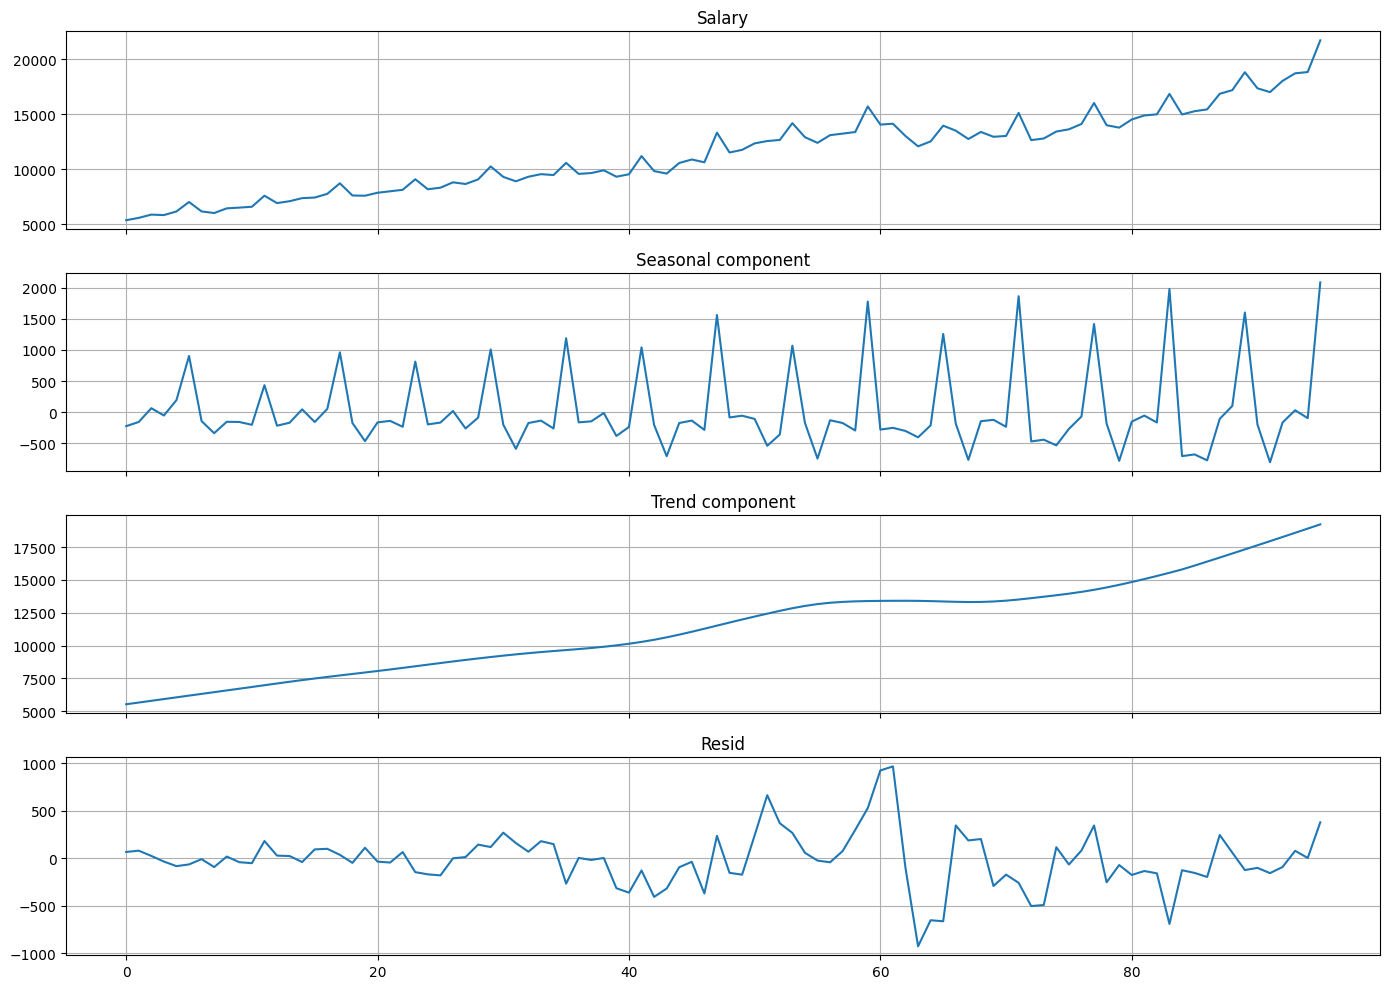

In [206]:
stl = STL(salary['Salary'], period=12)
result = stl.fit()

salary['seasonal'] = result.seasonal
salary['trend'] = result.trend
salary['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['Salary', 'seasonal', 'trend', 'resid']
titles = ['Salary', 'Seasonal component', 'Trend component', 'Resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(salary.index, salary[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [207]:
df["salary"] = salary['resid']

In [208]:
unemployment = pd.read_csv("unemployment.csv")

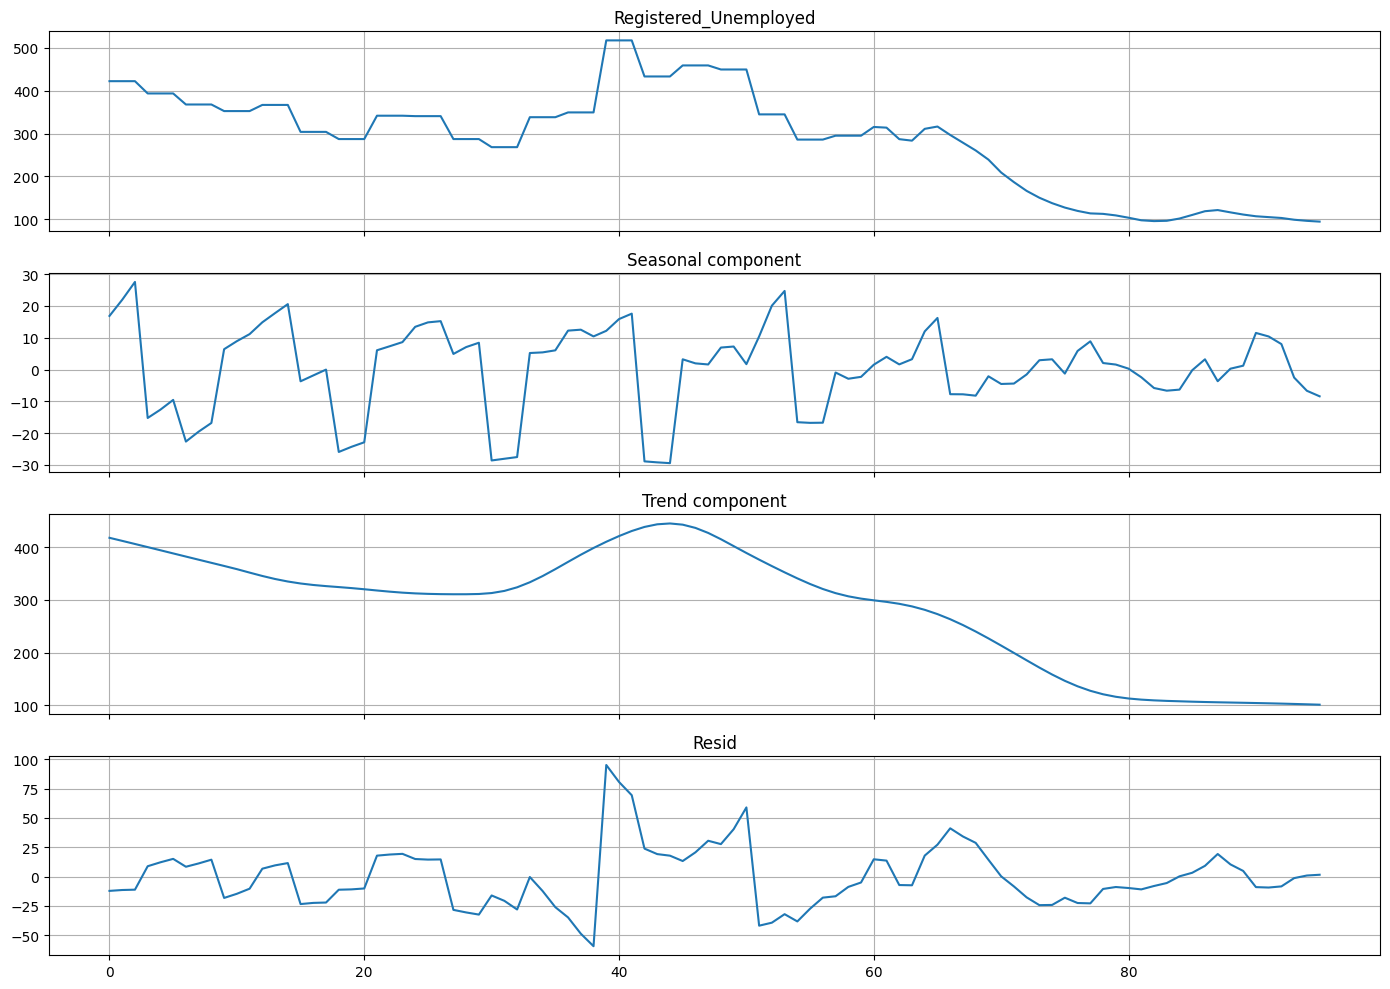

In [209]:
stl = STL(unemployment['Registered_Unemployed'], period=12)
result = stl.fit()

unemployment['seasonal'] = result.seasonal
unemployment['trend'] = result.trend
unemployment['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['Registered_Unemployed', 'seasonal', 'trend', 'resid']
titles = ['Registered_Unemployed', 'Seasonal component', 'Trend component', 'Resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(unemployment.index, unemployment[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [210]:
df["unemployed"] = unemployment['resid']

In [211]:
taxes = pd.read_csv("nadkhodzhennia_podatkiv_2017_2024.csv")

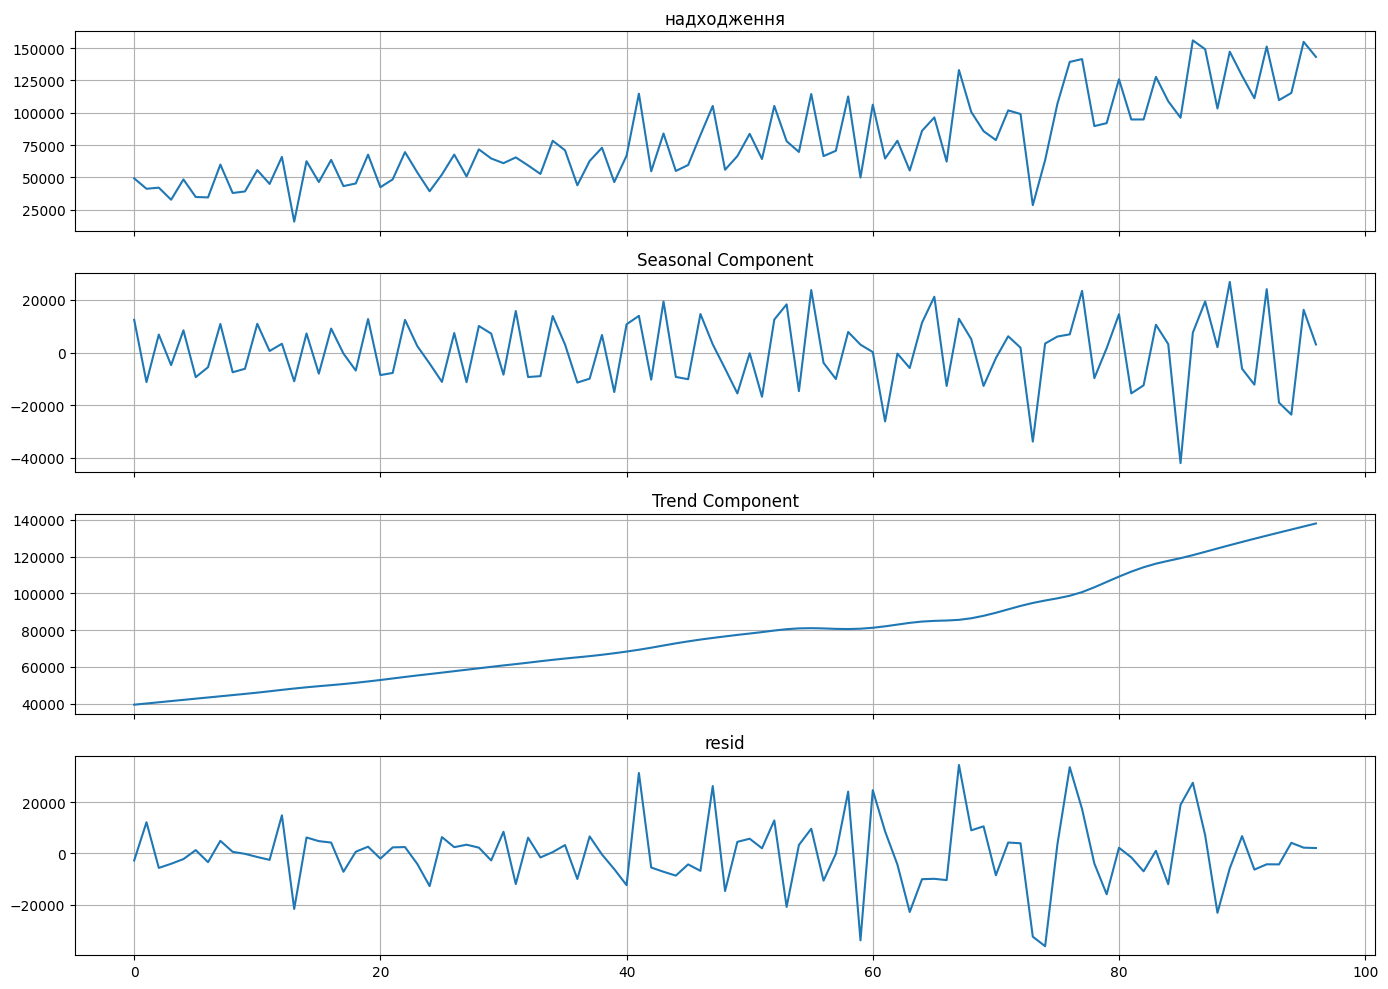

In [212]:
stl = STL(taxes['надходження'], period=12)
result = stl.fit()

taxes['seasonal'] = result.seasonal
taxes['trend'] = result.trend
taxes['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['надходження', 'seasonal', 'trend', 'resid']
titles = ['надходження', 'Seasonal Component', 'Trend Component', 'resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(taxes.index, taxes[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [213]:
df["надходження"] = taxes['resid']

In [214]:
df["Місяць"] = df["Місяць"].str.replace(r"(\d{4})-M(\d{2})", r"\1-\2", regex=True)
df["Місяць"] = pd.to_datetime(df["Місяць"])

CPI

Skewness: 0.528108867038939
Kurtosis: -1.0800138150822172


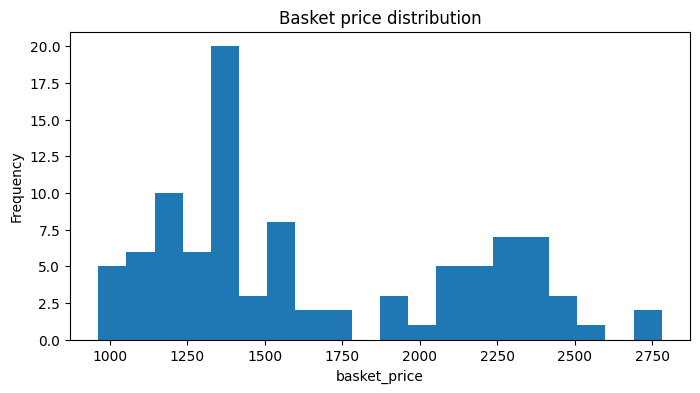

In [215]:
x = df["basket_price"]
print("Skewness:", skew(x))
print("Kurtosis:", kurtosis(x))

plt.figure(figsize=(8,4))
plt.hist(df["basket_price"], bins=20)
plt.title("Basket price distribution")
plt.xlabel("basket_price")
plt.ylabel("Frequency")
plt.show()

## 2. Construct model

In [216]:
df = pd.read_csv('basket_with_unemployment.csv')
unempl = pd.read_csv('unemployment.csv')
taxes = pd.read_csv('/Users/dariahannochenko/Documents/econometrics/project/good_basket_research/nadkhodzhennia_podatkiv_2017_2024.csv')

df['unemployment'] = unempl['Registered_Unemployed']
df['tax'] = taxes['надходження']
df['Місяць'] = pd.to_datetime(df['Місяць'])
df.set_index('Місяць', inplace=True)


df['basket_diff'] = df['basket_price'].diff()
df['unemployment_diff'] = df['unemployment'].diff()
df['tax_diff'] = df['tax'].diff()
df.dropna(inplace=True)

ADF Statistic: -5.819470295218252
p-value: 4.2159978325283904e-07


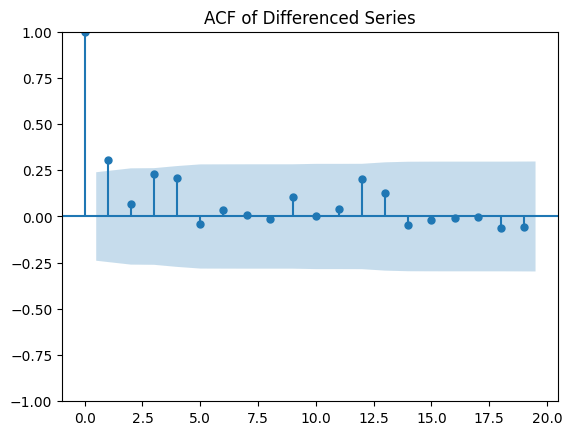

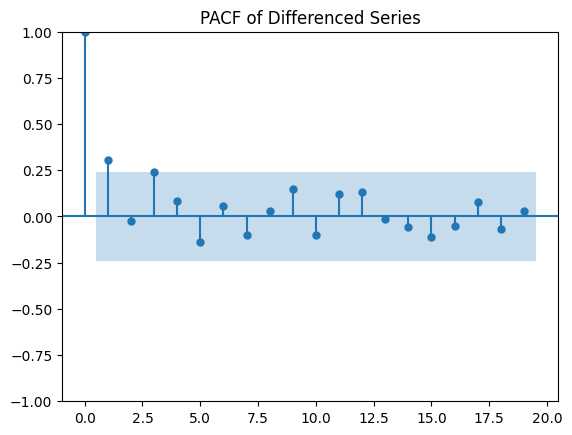

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            basket_diff   No. Observations:                   67
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -297.686
Date:                Fri, 09 May 2025   AIC                            617.372
Time:                        20:07:43   BIC                            641.624
Sample:                    06-01-2017   HQIC                           626.969
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.1738      5.945      2.048      0.041       0.523      23.825
covid                 4.3578     10.953      0.398      0.691     -17.110      25.826
covid_t_1           -41.

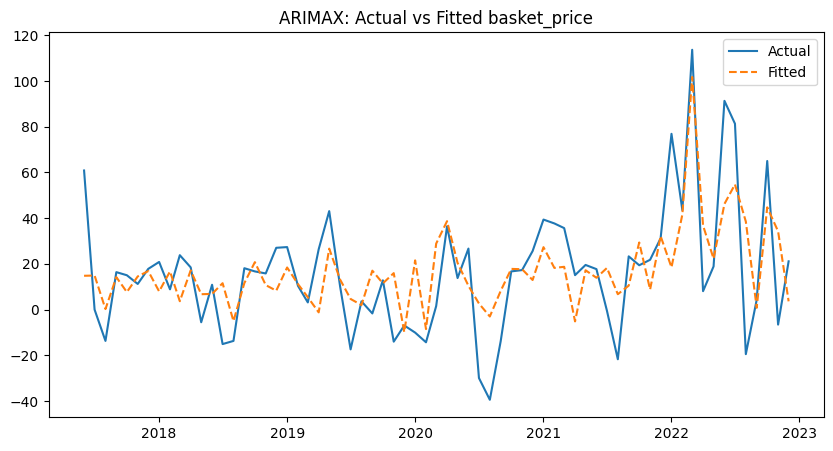

In [217]:
df['covid'] = ((df.index >= '2020-03-19') & (df.index <= '2021-03-19')).astype(int)
df['war'] = ((df.index >= '2022-02-24') & (df.index <= '2024-01-31')).astype(int)
df['covid_t_1'] = df['war'].shift(1)
df['covid_t_2'] = df['war'].shift(2)
df['covid_t_3'] = df['war'].shift(3)
df['war_t_1'] = df['war'].shift(1)
df['war_t_2'] = df['war'].shift(2)
df['prewar'] = ((df.index >= '2021-06-01') & (df.index <= '2022-01-31')).astype(int)

# result = adfuller(df['basket_price'])
# print("ADF Statistic:", result[0])
# print("p-value:", result[1])

df['basket_diff'] = df['basket_price'].diff()
df.dropna(inplace=True)
result_basket_diff = adfuller(df['basket_diff'])
print("ADF Statistic:", result_basket_diff[0])
print("p-value:", result_basket_diff[1])

# df.dropna(inplace=True)
result = seasonal_decompose(df['salary'], model='additive', period=12)
df['salary_deseasonalized'] = df['salary'] - result.seasonal


df['salary_diff_desea'] = df['salary_deseasonalized'].diff()

df.dropna(inplace=True)


plot_acf(df['basket_diff'])
plt.title("ACF of Differenced Series")
plt.show()

plot_pacf(df['basket_diff'])
plt.title("PACF of Differenced Series")
plt.show()

model =ARIMA(df['basket_diff'], order=(1,0,1), exog=df[['covid', 'covid_t_1', 'prewar', 'war', 'war_t_1', 'salary_diff_desea', 'unemployment_diff']])
results = model.fit()


print(results.summary())


plt.figure(figsize=(10, 5))
plt.plot(df.index, df['basket_diff'], label='Actual')
plt.plot(df.index, results.fittedvalues, label='Fitted', linestyle='--')
plt.title("ARIMAX: Actual vs Fitted basket_price")
plt.legend()
plt.show()


In [218]:
exog_restricted = ['covid', 'war']
model_restricted = ARIMA(df['basket_diff'], order=(1, 0, 1), exog=df[exog_restricted])
results_restricted = model_restricted.fit()


cov_matrix = results.cov_params()
beta_war = results.params['war']
beta_covid = results.params['covid']

se_diff = np.sqrt(
    cov_matrix.loc['war', 'war'] +
    cov_matrix.loc['covid', 'covid'] -
    2 * cov_matrix.loc['war', 'covid']
)

t_stat = (beta_war - beta_covid) / se_diff
p_value_contrast = 1 - norm.cdf(t_stat)

print(f"H1: Contrast Test (War > COVID)")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value (one-sided): {p_value_contrast:.4f}")
if p_value_contrast < 0.05:
    print("War has significantly stronger impact than COVID.\n")
else:
    print("No significant difference.\n")


lr_stat = -2 * (results_restricted.llf - results.llf)
df_diff = len(results.model.exog_names) - len(results_restricted.model.exog_names)
p_value_lr = 1 - chi2.cdf(lr_stat, df_diff)

print(f"H2: Likelihood Ratio Test (Macro variables matter)")
print(f"LR statistic: {lr_stat:.3f}")
print(f"Degrees of freedom: {df_diff}")
print(f"p-value: {p_value_lr:.4f}")
if p_value_lr < 0.05:
    print("Macroeconomic variables significantly improve the model.\n")
else:
    print("No significant improvement from macro variables.\n")


H1: Contrast Test (War > COVID)
t-statistic: 3.554
p-value (one-sided): 0.0002
War has significantly stronger impact than COVID.

H2: Likelihood Ratio Test (Macro variables matter)
LR statistic: 23.825
Degrees of freedom: 5
p-value: 0.0002
Macroeconomic variables significantly improve the model.



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [219]:
residuals = results.resid

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat:.4f}')

Durbin-Watson statistic: 1.9170


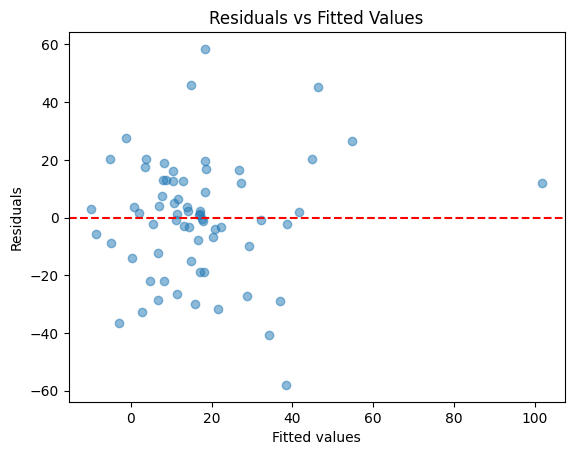

In [220]:
fitted_vals = results.fittedvalues
residuals = results.resid

plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()
